In [2]:
# iPython extension to autoreload modules when changes are made without restarting kernel
%load_ext autoreload
%autoreload 2

## Create Environment and Set up Simulation 

In [3]:
from functions.simulation_setup import set_schema_buildings, set_active_observations, set_schema_simulation_period
from citylearn.data import DataSet


print('All CityLearn datasets:', sorted(DataSet().get_dataset_names()))
DATASET_NAME = 'citylearn_challenge_2022_phase_all'
schema = DataSet().get_schema(DATASET_NAME)

RANDOM_SEED = 0
BUILDING_COUNT = 2
DAY_COUNT = 7
ACTIVE_OBSERVATIONS = ['hour', 'month']

schema, buildings = set_schema_buildings(schema, BUILDING_COUNT, RANDOM_SEED)
schema, simulation_start_time_step, simulation_end_time_step =\
    set_schema_simulation_period(schema, DAY_COUNT, RANDOM_SEED)
schema = set_active_observations(schema, ACTIVE_OBSERVATIONS)
schema['central_agent'] = True


print('Selected buildings:', buildings)
print(
    f'Selected {DAY_COUNT}-day period time steps:',
    (simulation_start_time_step, simulation_end_time_step)
)
print(f'Active observations:', ACTIVE_OBSERVATIONS)


All CityLearn datasets: ['baeda_3dem', 'ca_alameda_county_neighborhood', 'citylearn_challenge_2020_climate_zone_1', 'citylearn_challenge_2020_climate_zone_2', 'citylearn_challenge_2020_climate_zone_3', 'citylearn_challenge_2020_climate_zone_4', 'citylearn_challenge_2021', 'citylearn_challenge_2022_phase_1', 'citylearn_challenge_2022_phase_2', 'citylearn_challenge_2022_phase_3', 'citylearn_challenge_2022_phase_all', 'citylearn_challenge_2022_phase_all_plus_evs', 'citylearn_challenge_2023_phase_1', 'citylearn_challenge_2023_phase_2_local_evaluation', 'citylearn_challenge_2023_phase_2_online_evaluation_1', 'citylearn_challenge_2023_phase_2_online_evaluation_2', 'citylearn_challenge_2023_phase_2_online_evaluation_3', 'citylearn_challenge_2023_phase_3_1', 'citylearn_challenge_2023_phase_3_2', 'citylearn_challenge_2023_phase_3_3', 'quebec_neighborhood_with_demand_response_set_points', 'quebec_neighborhood_without_demand_response_set_points', 'tx_travis_county_neighborhood', 'vt_chittenden_co

## Base Agent

In [4]:
from agents.baseagent import Agent, BaselineAgent
from citylearn.citylearn import CityLearnEnv

base_env = CityLearnEnv(schema, random_seed=RANDOM_SEED)
base_agent = BaselineAgent(base_env, random_seed=RANDOM_SEED)

# Initialize Environment
observations, _ = base_env.reset()

while not base_env.terminated:
    actions = base_agent.predict(observations)
    observations, reward, info, terminated, truncated = base_env.step(actions)

# test
kpis = base_agent.env.evaluate()
kpis = kpis.pivot(index='cost_function', columns='name', values='value').round(3)
kpis = kpis.dropna(how='all')


In [7]:
# A general environment with discrete observations and actions that can be re-used for multiple agent types
from functions.wrappers import DiscreteAlgorithmWrapper

discrete_env = CityLearnEnv(schema, random_seed=RANDOM_SEED)
# Very Large bins and low multiplier for testing purposes

# define active observations and actions and their bin sizes
observation_bins = {'hour': 24, 'month':12}
action_bins = {'electrical_storage': 2, 'heating_storage': 2}

# Timesteps of simulation per possible state-action pair when simulating
# Higher for more computationally intensive, more thorough simulations
execution_multiplier = 3

# initialize list of bin sizes where each building
# has a dictionary in the list definining its bin sizes
observation_bin_sizes = []
action_bin_sizes = []

for b in discrete_env.buildings:
    # add a bin size definition for the buildings
    observation_bin_sizes.append(observation_bins)
    action_bin_sizes.append(action_bins)

unwrapped_env = DiscreteAlgorithmWrapper(
    discrete_env.unwrapped,
    observation_bin_sizes=observation_bin_sizes,
    action_bin_sizes=action_bin_sizes
)
m = unwrapped_env.observation_space[0].n
n = unwrapped_env.action_space[0].n
t = unwrapped_env.time_steps - 1
num_episodes = int(m*n*execution_multiplier/t)
print('Q-Table dimension:', (m, n))
print('Number of episodes to train:', num_episodes)


Q-Table dimension: (324, 4)
Number of episodes to train: 23


c:\Users\raffy\miniconda3\envs\citylearn\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.time_steps to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.time_steps` for environment variables or `env.get_wrapper_attr('time_steps')` that will search the reminding wrappers.
  logger.warn(


# Train Tabular Models
## Q-Learning
Sampling based on CityLearn Implementation to create framework for how we will test and implement our new algorithms

In [8]:
from agents.q_learning import QLearning
from IPython.display import display

# This made for Tabular Q learning, but I think it applies to any discrete algorithm
q_env = CityLearnEnv(schema, random_seed=RANDOM_SEED)
q_env = DiscreteAlgorithmWrapper(
    q_env.unwrapped,
    observation_bin_sizes=observation_bin_sizes,
    action_bin_sizes=action_bin_sizes
)

q_kwargs = {
    'epsilon': 1.0,
    'epsilon_decay': True,
    'learning_rate': 0.005,
    'discount_factor': 0.99,
}

q_agent = QLearning(
    env=q_env,
    random_seed=RANDOM_SEED,
    **q_kwargs
)

# ----------------- Train -----------------
_ = q_agent.learn(episodes=num_episodes)

# ----------------- Test -----------------
# Initialize Environment
observations, _ = q_env.reset()

while not q_env.terminated:
    actions = q_agent.predict(observations, True)
    observations, reward, info, terminated, truncated = q_env.step(actions)

kpis = q_agent.env.evaluate()
kpis = kpis.pivot(index='cost_function', columns='name', values='value').round(3)
kpis = kpis.dropna(how='all')
display(kpis)

c:\Users\raffy\miniconda3\envs\citylearn\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.observation_names to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.observation_names` for environment variables or `env.get_wrapper_attr('observation_names')` that will search the reminding wrappers.
  logger.warn(
100%|██████████| 23/23 [00:14<00:00,  1.56it/s]
c:\Users\raffy\miniconda3\envs\citylearn\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.terminated to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.terminated` for environment variables or `env.get_wrapper_attr('terminated')` that will search the reminding wrappers.
  logger.warn(
c:\Users\raffy\miniconda3\envs\citylearn\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.evaluate to get variables from other wrappers is deprecated and will be 

name                                     Building_2  Building_7  District
cost_function                                                            
all_time_peak_average                           NaN         NaN     1.494
annual_normalized_unserved_energy_total       0.000       0.000     0.000
carbon_emissions_total                        1.410       1.333     1.372
cost_total                                    1.378       1.168     1.273
daily_one_minus_load_factor_average             NaN         NaN     0.968
daily_peak_average                              NaN         NaN     1.616
discomfort_cold_delta_average                 0.000       0.000     0.000
discomfort_cold_delta_maximum                 0.000       0.000     0.000
discomfort_cold_delta_minimum                 0.000       0.000     0.000
discomfort_hot_delta_average                  0.000       0.000     0.000
discomfort_hot_delta_maximum                  0.000       0.000     0.000
discomfort_hot_delta_minimum                  0.000       0.000     0.000
electricity_consumption_total                 1.323       1.263     1.293
monthly_one_minus_load_factor_average           NaN         NaN     0.981
ramping_average                                 NaN         NaN     2.023
zero_net_energy                               0.658       0.131     0.395

## SARSA Model

In [9]:
from agents.sarsa import Sarsa

sarsa_env = CityLearnEnv(schema, random_seed=RANDOM_SEED)
sarsa_env = DiscreteAlgorithmWrapper(
    sarsa_env.unwrapped,
    observation_bin_sizes=observation_bin_sizes,
    action_bin_sizes=action_bin_sizes
)

sarsa_kwargs = {
    'epsilon': 0.1,
    'alpha': 0.005,
    'gamma': 0.99,
}


sarsa_agent = Sarsa(
    env=sarsa_env,
    random_seed=RANDOM_SEED,
    **sarsa_kwargs
)
# ----------------- Train -----------------
_ = sarsa_agent.learn(episodes=num_episodes)

# ----------------- Test -----------------
# Initialize Environment
observations, _ = sarsa_env.reset()

while not sarsa_env.terminated:
    actions = sarsa_agent.predict(observations, True)
    observations, reward, info, terminated, truncated = sarsa_env.step(actions)

kpis = sarsa_agent.env.evaluate()
kpis = kpis.pivot(index='cost_function', columns='name', values='value').round(3)
kpis = kpis.dropna(how='all')
display(kpis)

c:\Users\raffy\miniconda3\envs\citylearn\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.observation_names to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.observation_names` for environment variables or `env.get_wrapper_attr('observation_names')` that will search the reminding wrappers.
  logger.warn(
c:\Users\raffy\miniconda3\envs\citylearn\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.terminated to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.terminated` for environment variables or `env.get_wrapper_attr('terminated')` that will search the reminding wrappers.
  logger.warn(
c:\Users\raffy\miniconda3\envs\citylearn\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.evaluate to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do

name                                     Building_2  Building_7  District
cost_function                                                            
all_time_peak_average                           NaN         NaN     3.185
annual_normalized_unserved_energy_total       0.000       0.000     0.000
carbon_emissions_total                        2.209       1.843     2.026
cost_total                                    2.455       1.705     2.080
daily_one_minus_load_factor_average             NaN         NaN     0.952
daily_peak_average                              NaN         NaN     3.991
discomfort_cold_delta_average                 0.000       0.000     0.000
discomfort_cold_delta_maximum                 0.000       0.000     0.000
discomfort_cold_delta_minimum                 0.000       0.000     0.000
discomfort_hot_delta_average                  0.000       0.000     0.000
discomfort_hot_delta_maximum                  0.000       0.000     0.000
discomfort_hot_delta_minimum                  0.000       0.000     0.000
electricity_consumption_total                 2.180       1.949     2.064
monthly_one_minus_load_factor_average           NaN         NaN     0.972
ramping_average                                 NaN         NaN     3.733
zero_net_energy                               0.149      -0.262    -0.056

# Train Function Approximation Models
## Soft-Actor Critic

In [10]:
from agents.sac import SAC
from citylearn.wrappers import NormalizedObservationWrapper

num_episodes = 30
sac_env = CityLearnEnv(schema, random_seed=RANDOM_SEED, central_agent=False)

sac_kwargs = {
    'mini_batch_size':5,
    'tau': 0.005,
    'entropy_coeff': 0.2,
    'gamma': 0.99,
}


sac_agent = SAC(
    env=sac_env,
    random_seed=RANDOM_SEED,
    **sac_kwargs
)
# ----------------- Train -----------------
_ = sac_agent.learn(episodes=num_episodes)

# ----------------- Test -----------------
# Initialize Environment
observations, _ = sac_env.reset()
sac_actions = []
while not sac_env.terminated:
    actions = sac_agent.predict(observations, deterministic=True)
    observations, reward, info, terminated, truncated = sac_env.step(actions)
    sac_actions.append(actions)

kpis = sac_agent.env.evaluate()
kpis = kpis.pivot(index='cost_function', columns='name', values='value').round(3)
kpis = kpis.dropna(how='all')
display(kpis)

  0%|          | 0/30 [00:00<?, ?it/s]c:\Users\raffy\Documents\GitHub\Fa24-CS-138-FinalProject\agents\sac.py:96: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  actions = torch.FloatTensor(actions, device=self.device)


tensor([[0.7336]], grad_fn=<AddBackward0>)
tensor([[0.3130]], grad_fn=<AddBackward0>)
tensor([[ 0.4577],
        [ 0.9611],
        [ 1.2164],
        [-0.1213],
        [ 0.5219]], grad_fn=<AddBackward0>)
tensor([[0.6347],
        [0.5635],
        [0.6117],
        [0.6085],
        [0.6497]], grad_fn=<AddBackward0>)
tensor([[-1.0117],
        [-0.3098],
        [-0.1290],
        [-0.0650],
        [-0.1051]], grad_fn=<AddBackward0>)
tensor([[-1.2687],
        [-0.5321],
        [-1.9589],
        [ 0.4732],
        [ 1.0536]], grad_fn=<AddBackward0>)
tensor([[0.7026]], grad_fn=<AddBackward0>)
tensor([[0.0325]], grad_fn=<AddBackward0>)
tensor([[ 0.1596],
        [ 0.4833],
        [-0.2948],
        [ 0.0505],
        [ 0.9764]], grad_fn=<AddBackward0>)
tensor([[ 0.2811],
        [ 0.3943],
        [ 0.5146],
        [ 0.2759],
        [-0.3322]], grad_fn=<AddBackward0>)
tensor([[ 0.2100],
        [-0.0892],
        [ 0.8904],
        [ 1.3403],
        [ 0.8424]], grad_fn=<AddBackw

  3%|▎         | 1/30 [00:03<01:30,  3.13s/it]

tensor([[-10.4967],
        [ -8.2232],
        [ -7.7696],
        [ -8.2667],
        [ -6.8040]], grad_fn=<AddBackward0>)
tensor([[-11.6726],
        [ -1.9936],
        [ -3.6587],
        [-18.0142],
        [-19.9342]], grad_fn=<AddBackward0>)
tensor([[-13.5719],
        [-27.1272],
        [-30.1408],
        [-24.7503],
        [-15.8644]], grad_fn=<AddBackward0>)
tensor([[-10.6945],
        [-42.4433],
        [-28.9391],
        [-19.3703],
        [-35.2702]], grad_fn=<AddBackward0>)
tensor([[-26.1002]], grad_fn=<AddBackward0>)
tensor([[-28.6595]], grad_fn=<AddBackward0>)
tensor([[-29.5276],
        [ -5.4559],
        [-18.0121],
        [-16.8896],
        [-16.7762]], grad_fn=<AddBackward0>)
tensor([[-27.4016],
        [-16.9436],
        [ -3.1824],
        [ -9.7367],
        [-37.4232]], grad_fn=<AddBackward0>)
tensor([[-22.9170],
        [-19.8697],
        [-29.2077],
        [-16.7846],
        [-25.1853]], grad_fn=<AddBackward0>)
tensor([[ -8.5439],
        [-25.37

  7%|▋         | 2/30 [00:06<01:26,  3.09s/it]

tensor([[-25.0580],
        [-20.4076],
        [ -8.1179],
        [-19.1791],
        [-19.4247]], grad_fn=<AddBackward0>)
tensor([[-18.6255],
        [-29.1269],
        [-14.0155],
        [-32.8418],
        [-28.3204]], grad_fn=<AddBackward0>)
tensor([[-22.9818],
        [-24.9603],
        [-21.6862],
        [-24.3586],
        [-35.1570]], grad_fn=<AddBackward0>)
tensor([[-28.6588],
        [-30.8991],
        [-17.1421],
        [ -6.1137],
        [-39.9074]], grad_fn=<AddBackward0>)
tensor([[-26.6870]], grad_fn=<AddBackward0>)
tensor([[-41.5580]], grad_fn=<AddBackward0>)
tensor([[-17.6153],
        [ -4.3502],
        [-16.9887],
        [-32.1151],
        [-22.8652]], grad_fn=<AddBackward0>)
tensor([[-38.9897],
        [-21.5511],
        [-18.4646],
        [-36.5459],
        [-20.1427]], grad_fn=<AddBackward0>)
tensor([[-20.3588],
        [-12.6646],
        [-14.3955],
        [-29.1782],
        [-27.5887]], grad_fn=<AddBackward0>)
tensor([[-30.4063],
        [-18.91

 10%|█         | 3/30 [00:09<01:24,  3.13s/it]

tensor([[-26.4934]], grad_fn=<AddBackward0>)
tensor([[-74.7275]], grad_fn=<AddBackward0>)
tensor([[-16.2348],
        [-27.0822],
        [-31.0465],
        [-17.9593],
        [-28.6354]], grad_fn=<AddBackward0>)
tensor([[-35.0956],
        [-16.1826],
        [-31.8741],
        [-24.7240],
        [-30.3627]], grad_fn=<AddBackward0>)
tensor([[-40.2656],
        [-34.2082],
        [-37.4675],
        [-70.4533],
        [-54.2829]], grad_fn=<AddBackward0>)
tensor([[-67.1673],
        [-39.9133],
        [-35.4175],
        [-45.2565],
        [-37.8288]], grad_fn=<AddBackward0>)
tensor([[-24.0543]], grad_fn=<AddBackward0>)
tensor([[-20.6734]], grad_fn=<AddBackward0>)
tensor([[-15.7234],
        [-10.8631],
        [ -9.4839],
        [-13.3797],
        [-17.1388]], grad_fn=<AddBackward0>)
tensor([[-25.0819],
        [-14.0171],
        [-14.8647],
        [-19.9697],
        [-30.0874]], grad_fn=<AddBackward0>)
tensor([[-36.7461],
        [-54.7287],
        [-65.7439],
        [-

 13%|█▎        | 4/30 [00:12<01:21,  3.15s/it]

tensor([[-20.4101],
        [-27.8952],
        [-21.0188],
        [-18.3231],
        [-27.6349]], grad_fn=<AddBackward0>)
tensor([[-20.9468],
        [-35.6990],
        [-30.4163],
        [-39.9633],
        [-20.7672]], grad_fn=<AddBackward0>)
tensor([[-45.0776],
        [-41.0071],
        [-28.0353],
        [-16.0371],
        [ -7.2056]], grad_fn=<AddBackward0>)
tensor([[-28.3084]], grad_fn=<AddBackward0>)
tensor([[-31.3575]], grad_fn=<AddBackward0>)
tensor([[  0.7084],
        [ -9.1154],
        [ -4.3246],
        [-29.0817],
        [-24.6159]], grad_fn=<AddBackward0>)
tensor([[-15.5786],
        [-25.3191],
        [-33.9742],
        [-21.1142],
        [-12.1562]], grad_fn=<AddBackward0>)
tensor([[-21.2013],
        [-44.9156],
        [-23.4595],
        [-15.7657],
        [-26.7437]], grad_fn=<AddBackward0>)
tensor([[-19.4854],
        [-13.5835],
        [-35.1214],
        [-22.7710],
        [-33.5734]], grad_fn=<AddBackward0>)
tensor([[-20.1767]], grad_fn=<AddBa

 17%|█▋        | 5/30 [00:15<01:17,  3.09s/it]

tensor([[-17.0864],
        [-39.3462],
        [-77.2528],
        [-23.6956],
        [-25.2908]], grad_fn=<AddBackward0>)
tensor([[-31.2307],
        [-52.2073],
        [-59.8052],
        [-16.6851],
        [-31.9085]], grad_fn=<AddBackward0>)
tensor([[-43.5323],
        [-22.8821],
        [-24.2683],
        [-52.5167],
        [-46.6906]], grad_fn=<AddBackward0>)
tensor([[-37.3830],
        [-36.6168],
        [-38.5118],
        [-46.8512],
        [-63.0845]], grad_fn=<AddBackward0>)
tensor([[-40.0751]], grad_fn=<AddBackward0>)
tensor([[-50.2175]], grad_fn=<AddBackward0>)
tensor([[-67.9357],
        [-68.5739],
        [-65.6289],
        [-41.6276],
        [-57.7512]], grad_fn=<AddBackward0>)
tensor([[-65.9564],
        [-59.4802],
        [-60.4162],
        [-41.0188],
        [-58.4557]], grad_fn=<AddBackward0>)
tensor([[-40.4888],
        [-13.4745],
        [-15.3316],
        [-29.1031],
        [-27.9694]], grad_fn=<AddBackward0>)
tensor([[-33.4085],
        [ -9.24

 20%|██        | 6/30 [00:18<01:14,  3.11s/it]

tensor([[-35.9026],
        [-56.9824],
        [-19.8164],
        [-44.5143],
        [-51.6946]], grad_fn=<AddBackward0>)
tensor([[-29.2591],
        [-31.5115],
        [-11.2768],
        [-24.5635],
        [-33.1881]], grad_fn=<AddBackward0>)
tensor([[-26.5246],
        [-26.2036],
        [-15.2262],
        [-20.2289],
        [-28.9233]], grad_fn=<AddBackward0>)
tensor([[-42.0571]], grad_fn=<AddBackward0>)
tensor([[-40.2537]], grad_fn=<AddBackward0>)
tensor([[-48.7510],
        [-53.9296],
        [-17.3736],
        [-15.5009],
        [-27.7360]], grad_fn=<AddBackward0>)
tensor([[-45.6563],
        [-39.8805],
        [-34.4163],
        [-24.3564],
        [-20.7033]], grad_fn=<AddBackward0>)
tensor([[-11.6863],
        [ -6.2550],
        [-35.8171],
        [-43.3656],
        [-17.0742]], grad_fn=<AddBackward0>)
tensor([[-16.9203],
        [-22.9807],
        [-32.8159],
        [-18.0267],
        [-28.3916]], grad_fn=<AddBackward0>)
tensor([[-53.8263]], grad_fn=<AddBa

 23%|██▎       | 7/30 [00:21<01:10,  3.07s/it]

tensor([[-49.3586],
        [-24.2501],
        [-30.6243],
        [-27.0448],
        [-15.0975]], grad_fn=<AddBackward0>)
tensor([[-29.3085],
        [-40.5736],
        [-49.3728],
        [-44.9142],
        [-20.9904]], grad_fn=<AddBackward0>)
tensor([[-28.9711]], grad_fn=<AddBackward0>)
tensor([[-38.5489]], grad_fn=<AddBackward0>)
tensor([[-15.2474],
        [-36.8075],
        [-35.5857],
        [-28.5836],
        [-19.9199]], grad_fn=<AddBackward0>)
tensor([[-10.6558],
        [-43.9355],
        [-21.0445],
        [-20.2702],
        [-40.5821]], grad_fn=<AddBackward0>)
tensor([[-32.5841],
        [-24.6861],
        [-34.0762],
        [-33.5103],
        [-12.6642]], grad_fn=<AddBackward0>)
tensor([[-19.1211],
        [-23.0596],
        [-26.7844],
        [-35.5144],
        [-19.0988]], grad_fn=<AddBackward0>)
tensor([[-22.8421]], grad_fn=<AddBackward0>)
tensor([[-39.5965]], grad_fn=<AddBackward0>)
tensor([[-27.1786],
        [-28.7735],
        [-13.5039],
        [-

 27%|██▋       | 8/30 [00:24<01:07,  3.06s/it]

tensor([[-44.0915],
        [-34.6694],
        [-74.5396],
        [-76.1891],
        [-83.9285]], grad_fn=<AddBackward0>)
tensor([[-53.8018],
        [-24.0914],
        [-86.3723],
        [-62.3918],
        [-77.4076]], grad_fn=<AddBackward0>)
tensor([[-25.6197]], grad_fn=<AddBackward0>)
tensor([[-58.9297]], grad_fn=<AddBackward0>)
tensor([[-40.9419],
        [-29.0828],
        [-36.0406],
        [-16.1591],
        [-15.6927]], grad_fn=<AddBackward0>)
tensor([[-27.1615],
        [-30.6422],
        [-41.3330],
        [ -6.0034],
        [-25.6273]], grad_fn=<AddBackward0>)
tensor([[-49.1363],
        [-56.2624],
        [-50.5424],
        [-46.2954],
        [-30.3257]], grad_fn=<AddBackward0>)
tensor([[-54.0041],
        [-42.9641],
        [-44.9778],
        [-59.8083],
        [-27.3816]], grad_fn=<AddBackward0>)
tensor([[-35.1291]], grad_fn=<AddBackward0>)
tensor([[-48.8278]], grad_fn=<AddBackward0>)
tensor([[-20.5165],
        [-29.3908],
        [-15.7211],
        [-

 30%|███       | 9/30 [00:27<01:03,  3.03s/it]

tensor([[-10.9157],
        [-12.5719],
        [-32.7884],
        [-10.3788],
        [-25.4823]], grad_fn=<AddBackward0>)
tensor([[-31.7041],
        [  8.7469],
        [-17.3509],
        [-11.5175],
        [-20.6486]], grad_fn=<AddBackward0>)
tensor([[-50.0495],
        [-69.2462],
        [-55.5599],
        [-24.1113],
        [-75.2012]], grad_fn=<AddBackward0>)
tensor([[-54.2664],
        [-74.8435],
        [-49.8833],
        [-34.3499],
        [-40.3401]], grad_fn=<AddBackward0>)
tensor([[-10.8338]], grad_fn=<AddBackward0>)
tensor([[-42.0909]], grad_fn=<AddBackward0>)
tensor([[-20.7000],
        [ -9.4086],
        [-22.2705],
        [-27.5733],
        [-25.2037]], grad_fn=<AddBackward0>)
tensor([[-19.2649],
        [-10.5013],
        [-14.3884],
        [-20.2405],
        [-16.5748]], grad_fn=<AddBackward0>)
tensor([[-22.8339],
        [-32.4423],
        [-29.9252],
        [-56.3723],
        [-74.3612]], grad_fn=<AddBackward0>)
tensor([[-43.4603],
        [-28.25

 33%|███▎      | 10/30 [00:30<01:01,  3.07s/it]

tensor([[-14.5645],
        [-18.6358],
        [-24.2744],
        [-12.6834],
        [ -9.8604]], grad_fn=<AddBackward0>)
tensor([[-23.0642],
        [-25.3404],
        [-17.0322],
        [ -5.7005],
        [-10.2105]], grad_fn=<AddBackward0>)
tensor([[ -82.0889],
        [ -97.7823],
        [ -75.9679],
        [-127.8393],
        [ -70.6235]], grad_fn=<AddBackward0>)
tensor([[ -76.8243],
        [ -84.2333],
        [ -76.1949],
        [-127.9258],
        [ -64.1769]], grad_fn=<AddBackward0>)
tensor([[-18.6037]], grad_fn=<AddBackward0>)
tensor([[-131.5771]], grad_fn=<AddBackward0>)
tensor([[-20.1273],
        [-11.5113],
        [-20.1424],
        [-30.2857],
        [-21.4678]], grad_fn=<AddBackward0>)
tensor([[ -9.6116],
        [-14.5058],
        [-18.5796],
        [-10.8298],
        [ -7.0101]], grad_fn=<AddBackward0>)
tensor([[-104.2779],
        [-157.2947],
        [-102.7910],
        [ -92.5119],
        [-150.5244]], grad_fn=<AddBackward0>)
tensor([[ -98.4210]

 37%|███▋      | 11/30 [00:33<00:57,  3.05s/it]

tensor([[-20.8640],
        [ -5.1819],
        [ -9.7273],
        [-18.4609],
        [-15.6561]], grad_fn=<AddBackward0>)
tensor([[-12.5323],
        [-15.3341],
        [ -4.8166],
        [-14.1590],
        [-21.5245]], grad_fn=<AddBackward0>)
tensor([[-42.8999],
        [-13.3601],
        [-52.4321],
        [-28.1786],
        [-27.8868]], grad_fn=<AddBackward0>)
tensor([[-43.9398],
        [-22.0459],
        [-29.2890],
        [-23.5269],
        [-16.1047]], grad_fn=<AddBackward0>)
tensor([[-1.7974]], grad_fn=<AddBackward0>)
tensor([[-35.1421]], grad_fn=<AddBackward0>)
tensor([[-16.9283],
        [-25.6393],
        [ -1.5461],
        [-11.4959],
        [ -1.1166]], grad_fn=<AddBackward0>)
tensor([[-17.2792],
        [-15.9730],
        [-12.8605],
        [-14.7261],
        [-15.0813]], grad_fn=<AddBackward0>)
tensor([[-27.5937],
        [-32.3434],
        [-48.5779],
        [-36.5836],
        [-26.3063]], grad_fn=<AddBackward0>)
tensor([[-33.1995],
        [-36.753

 40%|████      | 12/30 [00:37<00:56,  3.13s/it]

tensor([[-30.0761],
        [-21.6284],
        [-19.4831],
        [-13.6428],
        [ -1.0056]], grad_fn=<AddBackward0>)
tensor([[-13.9707]], grad_fn=<AddBackward0>)
tensor([[-30.0675]], grad_fn=<AddBackward0>)
tensor([[ -3.4359],
        [-18.2221],
        [-29.8204],
        [-18.6582],
        [-18.9810]], grad_fn=<AddBackward0>)
tensor([[ -6.0115],
        [ -1.2269],
        [-27.2112],
        [-26.7975],
        [-26.5146]], grad_fn=<AddBackward0>)
tensor([[-32.6567],
        [-14.1139],
        [-16.5267],
        [-25.7942],
        [-16.9746]], grad_fn=<AddBackward0>)
tensor([[-44.1866],
        [-23.8161],
        [-24.8615],
        [-12.5967],
        [  3.7387]], grad_fn=<AddBackward0>)
tensor([[-20.9353]], grad_fn=<AddBackward0>)
tensor([[-6.6681]], grad_fn=<AddBackward0>)
tensor([[-19.8763],
        [-29.0001],
        [-17.9882],
        [-18.2408],
        [ -2.7958]], grad_fn=<AddBackward0>)
tensor([[-20.8123],
        [-21.5782],
        [-15.9663],
        [ -

 43%|████▎     | 13/30 [00:40<00:53,  3.14s/it]

tensor([[1.5072]], grad_fn=<AddBackward0>)
tensor([[-24.9081]], grad_fn=<AddBackward0>)
tensor([[ -9.0281],
        [ -8.8274],
        [-20.1538],
        [-14.8012],
        [ -4.4342]], grad_fn=<AddBackward0>)
tensor([[-18.1338],
        [ -6.3497],
        [-13.4768],
        [-19.3364],
        [-22.1118]], grad_fn=<AddBackward0>)
tensor([[ -7.5984],
        [ -5.6149],
        [ -9.9546],
        [-22.2418],
        [-27.5443]], grad_fn=<AddBackward0>)
tensor([[-14.8654],
        [-18.6774],
        [-18.8669],
        [-18.3456],
        [-14.1952]], grad_fn=<AddBackward0>)
tensor([[-24.0189]], grad_fn=<AddBackward0>)
tensor([[-26.8355]], grad_fn=<AddBackward0>)
tensor([[-26.5137],
        [-33.3787],
        [ -1.2685],
        [ -7.2268],
        [-13.0763]], grad_fn=<AddBackward0>)
tensor([[-12.8046],
        [-38.0612],
        [-16.9857],
        [-13.8589],
        [ -5.2090]], grad_fn=<AddBackward0>)
tensor([[ -3.3448],
        [-20.2288],
        [-21.4583],
        [-32

 47%|████▋     | 14/30 [00:43<00:50,  3.13s/it]

tensor([[-21.3819],
        [-12.8012],
        [-22.3022],
        [ -8.9161],
        [-18.3604]], grad_fn=<AddBackward0>)
tensor([[-4.3195]], grad_fn=<AddBackward0>)
tensor([[-18.3778]], grad_fn=<AddBackward0>)
tensor([[-22.3803],
        [ -2.0245],
        [-22.7130],
        [-15.6938],
        [-25.5662]], grad_fn=<AddBackward0>)
tensor([[-29.7660],
        [  5.3822],
        [-26.3392],
        [-15.2834],
        [ -9.5782]], grad_fn=<AddBackward0>)
tensor([[-23.3403],
        [ -5.8455],
        [-19.5738],
        [-14.9092],
        [-17.9789]], grad_fn=<AddBackward0>)
tensor([[-11.4521],
        [-23.9641],
        [-14.5073],
        [-19.0785],
        [-15.9612]], grad_fn=<AddBackward0>)
tensor([[-8.7908]], grad_fn=<AddBackward0>)
tensor([[-10.3000]], grad_fn=<AddBackward0>)
tensor([[-16.8412],
        [-11.8357],
        [ -6.9437],
        [  0.0660],
        [-34.4435]], grad_fn=<AddBackward0>)
tensor([[ -5.4829],
        [-14.3277],
        [-10.7690],
        [-14

 50%|█████     | 15/30 [00:47<00:50,  3.36s/it]

tensor([[-11.7527]], grad_fn=<AddBackward0>)
tensor([[-19.9911]], grad_fn=<AddBackward0>)
tensor([[ -3.8456],
        [-24.3748],
        [-14.1074],
        [-10.9174],
        [ -0.5679]], grad_fn=<AddBackward0>)
tensor([[-21.3574],
        [-21.0455],
        [-10.9208],
        [-13.1532],
        [ -7.2954]], grad_fn=<AddBackward0>)
tensor([[-18.4718],
        [-20.0036],
        [-25.9040],
        [-18.4193],
        [-20.6509]], grad_fn=<AddBackward0>)
tensor([[-25.3856],
        [-22.7920],
        [-15.5665],
        [-25.6583],
        [-20.3313]], grad_fn=<AddBackward0>)
tensor([[-20.8642]], grad_fn=<AddBackward0>)
tensor([[-16.5944]], grad_fn=<AddBackward0>)
tensor([[-15.8194],
        [-29.5302],
        [-25.6760],
        [-10.4263],
        [-11.7867]], grad_fn=<AddBackward0>)
tensor([[-28.5560],
        [-25.8563],
        [-22.2563],
        [ -1.3701],
        [ -4.8237]], grad_fn=<AddBackward0>)
tensor([[-27.0027],
        [-30.0019],
        [-16.8648],
        [-

 53%|█████▎    | 16/30 [00:50<00:47,  3.38s/it]

tensor([[-33.8049]], grad_fn=<AddBackward0>)
tensor([[-51.0158]], grad_fn=<AddBackward0>)
tensor([[-25.6627],
        [-37.3432],
        [-36.2042],
        [-25.4575],
        [-26.3381]], grad_fn=<AddBackward0>)
tensor([[-31.9055],
        [-22.0557],
        [-29.4835],
        [-24.6415],
        [-32.6694]], grad_fn=<AddBackward0>)
tensor([[-37.6107],
        [-29.5081],
        [-39.7011],
        [-42.3529],
        [-36.0841]], grad_fn=<AddBackward0>)
tensor([[-37.2356],
        [-33.2158],
        [-28.7272],
        [-45.2529],
        [-24.8377]], grad_fn=<AddBackward0>)
tensor([[-25.4740]], grad_fn=<AddBackward0>)
tensor([[-31.1890]], grad_fn=<AddBackward0>)
tensor([[-25.6120],
        [-17.7148],
        [-22.9339],
        [-17.8704],
        [-29.0503]], grad_fn=<AddBackward0>)
tensor([[-17.8714],
        [-31.6818],
        [-29.3193],
        [-31.8132],
        [-22.2593]], grad_fn=<AddBackward0>)
tensor([[-46.4503],
        [-42.6593],
        [-46.7187],
        [-

 57%|█████▋    | 17/30 [00:54<00:44,  3.42s/it]

tensor([[-11.4940],
        [ -5.2195],
        [-28.5661],
        [ -4.3778],
        [  9.3988]], grad_fn=<AddBackward0>)
tensor([[-26.4949],
        [-24.3651],
        [-34.5169],
        [-52.1134],
        [-37.1587]], grad_fn=<AddBackward0>)
tensor([[-41.1588],
        [-20.7718],
        [-21.6946],
        [-37.3303],
        [-35.3092]], grad_fn=<AddBackward0>)
tensor([[-5.2632]], grad_fn=<AddBackward0>)
tensor([[-32.9256]], grad_fn=<AddBackward0>)
tensor([[ -8.0659],
        [ -8.8703],
        [ -6.8450],
        [-17.6278],
        [ -5.3434]], grad_fn=<AddBackward0>)
tensor([[-23.2344],
        [-25.8864],
        [-11.6344],
        [-13.0711],
        [-21.4069]], grad_fn=<AddBackward0>)
tensor([[-18.4900],
        [-40.6895],
        [-34.0185],
        [-24.4308],
        [-19.3556]], grad_fn=<AddBackward0>)
tensor([[-13.5419],
        [-36.0115],
        [-34.9723],
        [-35.4155],
        [-34.5163]], grad_fn=<AddBackward0>)
tensor([[-1.2277]], grad_fn=<AddBack

 60%|██████    | 18/30 [00:57<00:39,  3.33s/it]

tensor([[ -8.5812],
        [-30.4073],
        [-25.2940],
        [-28.5665],
        [-19.7638]], grad_fn=<AddBackward0>)
tensor([[-7.2507]], grad_fn=<AddBackward0>)
tensor([[-25.1206]], grad_fn=<AddBackward0>)
tensor([[-12.5341],
        [-11.3626],
        [-17.4068],
        [-12.4277],
        [-25.7413]], grad_fn=<AddBackward0>)
tensor([[-19.3162],
        [-31.3003],
        [-34.7492],
        [-13.4663],
        [-31.7386]], grad_fn=<AddBackward0>)
tensor([[-31.1742],
        [ -8.0964],
        [-20.6702],
        [-15.7951],
        [-16.1875]], grad_fn=<AddBackward0>)
tensor([[-14.8380],
        [-23.7818],
        [-15.6931],
        [-15.2273],
        [-15.5099]], grad_fn=<AddBackward0>)
tensor([[-24.6291]], grad_fn=<AddBackward0>)
tensor([[-23.4492]], grad_fn=<AddBackward0>)
tensor([[-20.0712],
        [-17.8153],
        [-12.8391],
        [-20.3953],
        [-31.0236]], grad_fn=<AddBackward0>)
tensor([[-22.9804],
        [-29.2291],
        [-16.2932],
        [-1

 63%|██████▎   | 19/30 [01:00<00:36,  3.31s/it]

tensor([[-3.5558]], grad_fn=<AddBackward0>)
tensor([[-37.4594]], grad_fn=<AddBackward0>)
tensor([[-12.8038],
        [-12.9903],
        [ -6.7355],
        [-14.6249],
        [-26.1092]], grad_fn=<AddBackward0>)
tensor([[ -5.1671],
        [-23.7224],
        [-22.7537],
        [-30.3850],
        [-12.4848]], grad_fn=<AddBackward0>)
tensor([[ -5.9030],
        [-35.5162],
        [-32.9734],
        [-28.5329],
        [-27.4597]], grad_fn=<AddBackward0>)
tensor([[-26.0297],
        [-31.2852],
        [-36.6444],
        [-40.5281],
        [-16.8930]], grad_fn=<AddBackward0>)
tensor([[-17.9004]], grad_fn=<AddBackward0>)
tensor([[-22.3107]], grad_fn=<AddBackward0>)
tensor([[ -9.6623],
        [-14.2822],
        [-28.1010],
        [ -3.9117],
        [ -5.6207]], grad_fn=<AddBackward0>)
tensor([[-21.2720],
        [-21.8113],
        [-18.4473],
        [-14.7773],
        [-23.2640]], grad_fn=<AddBackward0>)
tensor([[-22.1452],
        [-40.9576],
        [-32.7128],
        [-3

 67%|██████▋   | 20/30 [01:03<00:32,  3.23s/it]

tensor([[-25.0156],
        [-21.6402],
        [-34.5099],
        [-19.5621],
        [-23.4439]], grad_fn=<AddBackward0>)
tensor([[-34.4735],
        [-33.0382],
        [-35.9538],
        [-24.1190],
        [-23.4811]], grad_fn=<AddBackward0>)
tensor([[-11.8426]], grad_fn=<AddBackward0>)
tensor([[-41.3420]], grad_fn=<AddBackward0>)
tensor([[-22.5376],
        [-31.1523],
        [-16.3178],
        [-37.2674],
        [-28.0026]], grad_fn=<AddBackward0>)
tensor([[-19.2082],
        [-28.7974],
        [-27.3720],
        [-28.9579],
        [-25.1139]], grad_fn=<AddBackward0>)
tensor([[-27.2041],
        [-29.1077],
        [-24.5449],
        [-30.9044],
        [-20.7489]], grad_fn=<AddBackward0>)
tensor([[-35.1036],
        [-15.4326],
        [-22.0434],
        [-29.3376],
        [-23.0940]], grad_fn=<AddBackward0>)
tensor([[-22.1794]], grad_fn=<AddBackward0>)
tensor([[-32.8451]], grad_fn=<AddBackward0>)
tensor([[-15.6220],
        [-29.9564],
        [-24.4734],
        [-

 70%|███████   | 21/30 [01:06<00:29,  3.22s/it]

tensor([[-23.2562],
        [-28.4963],
        [-26.0379],
        [-13.9950],
        [-17.9083]], grad_fn=<AddBackward0>)
tensor([[-30.2361],
        [-25.4300],
        [-18.8575],
        [-18.4712],
        [ -8.1967]], grad_fn=<AddBackward0>)
tensor([[-26.9703],
        [-31.4055],
        [-18.5915],
        [-29.4920],
        [-16.0786]], grad_fn=<AddBackward0>)
tensor([[-33.0533],
        [-15.8985],
        [-28.9797],
        [-26.5898],
        [-43.0563]], grad_fn=<AddBackward0>)
tensor([[-14.0634]], grad_fn=<AddBackward0>)
tensor([[-28.5976]], grad_fn=<AddBackward0>)
tensor([[-20.2842],
        [-22.1922],
        [-24.7511],
        [-27.2592],
        [-22.7331]], grad_fn=<AddBackward0>)
tensor([[-24.6930],
        [-20.3125],
        [-27.8431],
        [-21.5420],
        [-15.4079]], grad_fn=<AddBackward0>)
tensor([[-41.2304],
        [-33.0861],
        [-24.6607],
        [-18.0333],
        [-26.4381]], grad_fn=<AddBackward0>)
tensor([[-38.5517],
        [-39.96

 73%|███████▎  | 22/30 [01:10<00:27,  3.42s/it]

tensor([[-24.9150]], grad_fn=<AddBackward0>)
tensor([[-38.9131]], grad_fn=<AddBackward0>)
tensor([[-16.5615],
        [-30.9273],
        [-21.5940],
        [-11.1944],
        [-26.8562]], grad_fn=<AddBackward0>)
tensor([[-17.0281],
        [-13.2385],
        [ -4.8322],
        [-22.4659],
        [-14.5157]], grad_fn=<AddBackward0>)
tensor([[-27.2310],
        [ -7.5178],
        [-17.1048],
        [-18.1251],
        [-41.6343]], grad_fn=<AddBackward0>)
tensor([[-15.5398],
        [-31.0646],
        [-27.6729],
        [-36.3865],
        [-24.8859]], grad_fn=<AddBackward0>)
tensor([[-26.9001]], grad_fn=<AddBackward0>)
tensor([[-9.1592]], grad_fn=<AddBackward0>)
tensor([[ -9.9858],
        [ -1.8216],
        [-16.1892],
        [-36.0319],
        [-15.4519]], grad_fn=<AddBackward0>)
tensor([[ -9.4645],
        [-16.9585],
        [ -6.1878],
        [-23.3119],
        [-40.4579]], grad_fn=<AddBackward0>)
tensor([[-32.6370],
        [ -7.6810],
        [-36.0728],
        [-4

 77%|███████▋  | 23/30 [01:14<00:24,  3.46s/it]

tensor([[-17.7795]], grad_fn=<AddBackward0>)
tensor([[-11.3870]], grad_fn=<AddBackward0>)
tensor([[-28.6678],
        [-23.0609],
        [-26.4921],
        [-23.0490],
        [-14.6405]], grad_fn=<AddBackward0>)
tensor([[-13.8315],
        [-12.3579],
        [-22.4968],
        [-21.5565],
        [-19.1556]], grad_fn=<AddBackward0>)
tensor([[ -6.8861],
        [-15.1133],
        [-20.6139],
        [  9.6317],
        [ -5.3820]], grad_fn=<AddBackward0>)
tensor([[-30.4323],
        [-14.7953],
        [-13.9836],
        [-23.5610],
        [ -8.5324]], grad_fn=<AddBackward0>)
tensor([[-6.6381]], grad_fn=<AddBackward0>)
tensor([[-10.1171]], grad_fn=<AddBackward0>)
tensor([[ -9.6425],
        [-22.6119],
        [-23.3951],
        [-19.7808],
        [-34.6137]], grad_fn=<AddBackward0>)
tensor([[-25.7067],
        [-18.4872],
        [-18.0435],
        [-15.2344],
        [-16.1563]], grad_fn=<AddBackward0>)
tensor([[-15.3695],
        [-10.2469],
        [  0.7494],
        [-1

 80%|████████  | 24/30 [01:17<00:20,  3.34s/it]

tensor([[-19.5992],
        [ -6.7773],
        [-20.9328],
        [-20.9634],
        [-12.9985]], grad_fn=<AddBackward0>)
tensor([[ -4.4784],
        [-27.1955],
        [-12.2847],
        [-24.8288],
        [-14.1063]], grad_fn=<AddBackward0>)
tensor([[  2.5763],
        [-28.7503],
        [-12.6821],
        [-18.0407],
        [-12.1199]], grad_fn=<AddBackward0>)
tensor([[ -3.3585],
        [ -3.5816],
        [-12.3979],
        [-25.4656],
        [-21.1324]], grad_fn=<AddBackward0>)
tensor([[-18.2311]], grad_fn=<AddBackward0>)
tensor([[-10.7194]], grad_fn=<AddBackward0>)
tensor([[-13.0866],
        [-27.3052],
        [ -7.8041],
        [-31.1677],
        [-21.0709]], grad_fn=<AddBackward0>)
tensor([[-40.9207],
        [-16.3932],
        [-19.1901],
        [-13.9972],
        [-26.0969]], grad_fn=<AddBackward0>)
tensor([[ -9.3852],
        [-14.9107],
        [-16.6684],
        [-10.5946],
        [ -2.4654]], grad_fn=<AddBackward0>)
tensor([[-13.8144],
        [-22.85

 83%|████████▎ | 25/30 [01:20<00:16,  3.27s/it]

tensor([[-19.0362],
        [-12.6187],
        [-24.4535],
        [-20.4675],
        [-20.5189]], grad_fn=<AddBackward0>)
tensor([[-10.5013],
        [-24.2827],
        [-19.4000],
        [-16.6042],
        [-26.3727]], grad_fn=<AddBackward0>)
tensor([[-37.3887],
        [-27.8195],
        [-18.0779],
        [-22.9733],
        [-22.2947]], grad_fn=<AddBackward0>)
tensor([[-9.7590]], grad_fn=<AddBackward0>)
tensor([[-22.0476]], grad_fn=<AddBackward0>)
tensor([[-12.6548],
        [-35.4407],
        [-15.8781],
        [-19.7883],
        [ -5.2118]], grad_fn=<AddBackward0>)
tensor([[-14.4844],
        [-17.1542],
        [-21.8701],
        [-24.9078],
        [-16.9383]], grad_fn=<AddBackward0>)
tensor([[ -7.1700],
        [ -8.8220],
        [-23.9225],
        [-20.3571],
        [-20.1213]], grad_fn=<AddBackward0>)
tensor([[ -5.2470],
        [-11.3648],
        [-26.1638],
        [-15.9326],
        [-23.3088]], grad_fn=<AddBackward0>)
tensor([[-23.7945]], grad_fn=<AddBac

 87%|████████▋ | 26/30 [01:23<00:12,  3.21s/it]

tensor([[-37.8541],
        [-29.9264],
        [-44.1616],
        [-29.7949],
        [-28.9983]], grad_fn=<AddBackward0>)
tensor([[-38.6578],
        [-35.5174],
        [-39.2691],
        [-29.0005],
        [-28.9609]], grad_fn=<AddBackward0>)
tensor([[-28.8108]], grad_fn=<AddBackward0>)
tensor([[-39.5498]], grad_fn=<AddBackward0>)
tensor([[-34.6488],
        [-25.8882],
        [-27.4984],
        [-28.3376],
        [-40.4017]], grad_fn=<AddBackward0>)
tensor([[-20.5925],
        [-26.3935],
        [-29.7343],
        [-27.7182],
        [-33.7422]], grad_fn=<AddBackward0>)
tensor([[-27.1367],
        [-30.1438],
        [-27.2102],
        [-26.9716],
        [-38.8516]], grad_fn=<AddBackward0>)
tensor([[-32.1753],
        [-19.3114],
        [-33.8825],
        [-34.1823],
        [-27.3435]], grad_fn=<AddBackward0>)
tensor([[-32.3404]], grad_fn=<AddBackward0>)
tensor([[-45.8569]], grad_fn=<AddBackward0>)
tensor([[-12.6972],
        [-38.3887],
        [-29.2674],
        [-

 90%|█████████ | 27/30 [01:26<00:09,  3.18s/it]

tensor([[-5.1477]], grad_fn=<AddBackward0>)
tensor([[-16.7913]], grad_fn=<AddBackward0>)
tensor([[-24.9340],
        [-11.2320],
        [-10.7750],
        [-19.0556],
        [-25.9467]], grad_fn=<AddBackward0>)
tensor([[ -4.1408],
        [-26.0301],
        [-21.3740],
        [-18.2109],
        [-15.9007]], grad_fn=<AddBackward0>)
tensor([[ -2.8937],
        [ -8.7131],
        [-23.8900],
        [-18.1366],
        [-12.5311]], grad_fn=<AddBackward0>)
tensor([[-15.9224],
        [ -8.5484],
        [-15.0334],
        [-16.1506],
        [ -5.2888]], grad_fn=<AddBackward0>)
tensor([[-21.9963]], grad_fn=<AddBackward0>)
tensor([[-24.0481]], grad_fn=<AddBackward0>)
tensor([[ -6.0344],
        [-18.0884],
        [-23.7803],
        [-22.5726],
        [ -6.6017]], grad_fn=<AddBackward0>)
tensor([[-20.5615],
        [ -3.2472],
        [-11.9963],
        [-20.6860],
        [-22.2772]], grad_fn=<AddBackward0>)
tensor([[-26.8857],
        [-11.6815],
        [-13.2408],
        [-1

 93%|█████████▎| 28/30 [01:29<00:06,  3.14s/it]

tensor([[-18.8330],
        [-17.8721],
        [ -5.6645],
        [-18.7088],
        [ -6.6220]], grad_fn=<AddBackward0>)
tensor([[-16.1801],
        [ -1.2395],
        [-24.8205],
        [-18.8174],
        [-26.7108]], grad_fn=<AddBackward0>)
tensor([[-29.3393],
        [-20.8711],
        [-14.8974],
        [-14.0055],
        [-29.6438]], grad_fn=<AddBackward0>)
tensor([[-18.7346]], grad_fn=<AddBackward0>)
tensor([[-20.6864]], grad_fn=<AddBackward0>)
tensor([[-17.9206],
        [-21.1006],
        [-25.5063],
        [-23.2430],
        [ -5.8404]], grad_fn=<AddBackward0>)
tensor([[-16.7705],
        [-15.4477],
        [-19.1059],
        [ 10.9082],
        [-22.6547]], grad_fn=<AddBackward0>)
tensor([[-14.2715],
        [-16.5099],
        [-12.6470],
        [-23.5655],
        [-25.8365]], grad_fn=<AddBackward0>)
tensor([[-14.3432],
        [-15.9576],
        [-14.8727],
        [-12.4715],
        [-11.1502]], grad_fn=<AddBackward0>)
tensor([[-9.1223]], grad_fn=<AddBac

 97%|█████████▋| 29/30 [01:32<00:03,  3.13s/it]

tensor([[ -8.4811],
        [-23.0584],
        [-29.5473],
        [-10.0267],
        [-31.3157]], grad_fn=<AddBackward0>)
tensor([[-29.6306],
        [-23.1704],
        [-28.1955],
        [-20.3105],
        [-23.9761]], grad_fn=<AddBackward0>)
tensor([[  1.4939],
        [-11.2305],
        [-24.5943],
        [ -9.6498],
        [-27.3243]], grad_fn=<AddBackward0>)
tensor([[ -1.1565],
        [-15.9343],
        [-10.6218],
        [ -6.3924],
        [-42.8345]], grad_fn=<AddBackward0>)
tensor([[2.0618]], grad_fn=<AddBackward0>)
tensor([[-11.7309]], grad_fn=<AddBackward0>)
tensor([[-27.7331],
        [-18.4568],
        [-29.5380],
        [-26.7923],
        [-14.5086]], grad_fn=<AddBackward0>)
tensor([[-23.5802],
        [-21.7175],
        [-30.3210],
        [ -4.8840],
        [-22.3890]], grad_fn=<AddBackward0>)
tensor([[ -9.0274],
        [-22.8977],
        [-13.4401],
        [ -1.2894],
        [ -9.3511]], grad_fn=<AddBackward0>)
tensor([[ -8.3827],
        [-24.4527

100%|██████████| 30/30 [01:35<00:00,  3.20s/it]

tensor([[  0.0316],
        [-22.1898],
        [-29.0053],
        [-23.5672],
        [-17.2238]], grad_fn=<AddBackward0>)
tensor([[-31.0210],
        [-33.5146],
        [-15.6552],
        [-26.0015],
        [-15.4700]], grad_fn=<AddBackward0>)
tensor([[-6.1406]], grad_fn=<AddBackward0>)
tensor([[-34.3217]], grad_fn=<AddBackward0>)
tensor([[-12.9267],
        [-20.6875],
        [ -6.5342],
        [-19.1569],
        [ -1.2721]], grad_fn=<AddBackward0>)
tensor([[-13.2146],
        [-19.9019],
        [-12.6419],
        [-17.1464],
        [ -5.9154]], grad_fn=<AddBackward0>)
tensor([[-20.6725],
        [-27.0753],
        [-22.7026],
        [-25.7928],
        [-16.2086]], grad_fn=<AddBackward0>)
tensor([[-18.1504],
        [-23.9715],
        [-33.5700],
        [-31.7480],
        [-12.6146]], grad_fn=<AddBackward0>)
tensor([[-18.8179]], grad_fn=<AddBackward0>)
tensor([[-13.8300]], grad_fn=<AddBackward0>)
tensor([[-12.2755],
        [-29.6176],
        [-18.4134],
        [-1

tensor([[-11.3216]], grad_fn=<AddBackward0>)
tensor([[-15.6201]], grad_fn=<AddBackward0>)
tensor([[-24.6497]], grad_fn=<AddBackward0>)
tensor([[-9.0920]], grad_fn=<AddBackward0>)
tensor([[-17.7916]], grad_fn=<AddBackward0>)
tensor([[-22.5498]], grad_fn=<AddBackward0>)
tensor([[-25.8124]], grad_fn=<AddBackward0>)
tensor([[-13.6309]], grad_fn=<AddBackward0>)
tensor([[-17.7701]], grad_fn=<AddBackward0>)
tensor([[-33.9892]], grad_fn=<AddBackward0>)
tensor([[-14.9279]], grad_fn=<AddBackward0>)
tensor([[-21.0107]], grad_fn=<AddBackward0>)
tensor([[-6.6516]], grad_fn=<AddBackward0>)
tensor([[-26.7130]], grad_fn=<AddBackward0>)
tensor([[-5.8364]], grad_fn=<AddBackward0>)
tensor([[-12.0482]], grad_fn=<AddBackward0>)
tensor([[-14.2602]], grad_fn=<AddBackward0>)
tensor([[-17.8689]], grad_fn=<AddBackward0>)
tensor([[-14.9052]], grad_fn=<AddBackward0>)
tensor([[-17.7292]], grad_fn=<AddBackward0>)
tensor([[8.0926]], grad_fn=<AddBackward0>)
tensor([[-26.4182]], grad_fn=<AddBackward0>)
tensor([[-9.911

name                                     Building_2  Building_7  District
cost_function                                                            
all_time_peak_average                           NaN         NaN     2.108
annual_normalized_unserved_energy_total       0.000         0.0     0.000
carbon_emissions_total                        1.341         1.0     1.171
cost_total                                    1.400         1.0     1.200
daily_one_minus_load_factor_average             NaN         NaN     0.989
daily_peak_average                              NaN         NaN     1.755
discomfort_cold_delta_average                 0.000         0.0     0.000
discomfort_cold_delta_maximum                 0.000         0.0     0.000
discomfort_cold_delta_minimum                 0.000         0.0     0.000
discomfort_hot_delta_average                  0.000         0.0     0.000
discomfort_hot_delta_maximum                  0.000         0.0     0.000
discomfort_hot_delta_minimum                  0.000         0.0     0.000
electricity_consumption_total                 1.326         1.0     1.163
monthly_one_minus_load_factor_average           NaN         NaN     0.983
ramping_average                                 NaN         NaN     1.600
zero_net_energy                               0.740         1.0     0.870

## MADDPG

In [11]:
from agents.maddpg import MADDPGAgent, ReplayBuffer
import numpy as np
from tqdm import tqdm

# set up environment as 1 agent per building
schema['central_agent'] = False
MADDPG_env = CityLearnEnv(schema, random_seed=RANDOM_SEED)
obs = MADDPG_env.reset()

# set up parameters for agent and replay buffer
steps_per_episode = MADDPG_env.episode_time_steps
num_agents = len(MADDPG_env.buildings)
obs_dim = len(obs[0])
act_dim = MADDPG_env.action_space[0].shape[0]
device = 'cpu'

print(len(MADDPG_env.buildings))
print("Active Observations: ", MADDPG_env.observation_names)
print("Active Actions: ", MADDPG_env.action_names)

MADDPG_agent = MADDPGAgent(num_agents=num_agents, 
                           obs_dim=obs_dim, 
                           act_dim=act_dim,
                           device='cpu')

replay_buffer = ReplayBuffer(obs_dim=obs_dim, 
                             act_dim=act_dim,
                             num_agents=num_agents, 
                             device='cpu')

# ----------------- Train -----------------
for ep in tqdm(range(num_episodes)):
    obs, _ = MADDPG_env.reset()
    total_reward = 0.0
    for t in range(steps_per_episode):
        # Select actions with exploration
        action = MADDPG_agent.select_action(obs)

        # Step environment
        next_obs, rewards, done, *_ = MADDPG_env.step(action)

        # If rewards is a scalar or single value, broadcast to all agents
        if np.isscalar(rewards):
            rewards = np.array([rewards]*num_agents)

        # Store the transition
        replay_buffer.store(np.array(obs), np.array(action), rewards, np.array(next_obs), np.array([done]))

        # Update the agent (assuming enough samples)
        MADDPG_agent.update(replay_buffer)

        obs = next_obs
        total_reward += sum(rewards)

        if done:
            break

2
Active Observations:  [['month', 'hour'], ['month', 'hour']]
Active Actions:  [['electrical_storage'], ['electrical_storage']]


100%|██████████| 30/30 [01:23<00:00,  2.80s/it]


In [12]:
# ----------------- Test -----------------
# Initialize Environment
MADDPG_agent.noise_std = 0
observations, _ = MADDPG_env.reset()
done = False
mad_actions = []

while not done:
    actions = MADDPG_agent.select_action(observations)
    observations, reward, done, *_ = MADDPG_env.step(actions)

    mad_actions.append(actions)

kpis = MADDPG_env.evaluate()
kpis = kpis.pivot(index='cost_function', columns='name', values='value').round(3)
kpis = kpis.dropna(how='all')
display(kpis)

name                                     Building_2  Building_7  District
cost_function                                                            
all_time_peak_average                           NaN         NaN       1.0
annual_normalized_unserved_energy_total         0.0         0.0       0.0
carbon_emissions_total                          1.0         1.0       1.0
cost_total                                      1.0         1.0       1.0
daily_one_minus_load_factor_average             NaN         NaN       1.0
daily_peak_average                              NaN         NaN       1.0
discomfort_cold_delta_average                   0.0         0.0       0.0
discomfort_cold_delta_maximum                   0.0         0.0       0.0
discomfort_cold_delta_minimum                   0.0         0.0       0.0
discomfort_hot_delta_average                    0.0         0.0       0.0
discomfort_hot_delta_maximum                    0.0         0.0       0.0
discomfort_hot_delta_minimum                    0.0         0.0       0.0
electricity_consumption_total                   1.0         1.0       1.0
monthly_one_minus_load_factor_average           NaN         NaN       1.0
ramping_average                                 NaN         NaN       1.0
zero_net_energy                                 1.0         1.0       1.0

# Plot Performance

c:\Users\raffy\miniconda3\envs\citylearn\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.evaluate to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.evaluate` for environment variables or `env.get_wrapper_attr('evaluate')` that will search the reminding wrappers.
  logger.warn(
c:\Users\raffy\miniconda3\envs\citylearn\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.evaluate to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.evaluate` for environment variables or `env.get_wrapper_attr('evaluate')` that will search the reminding wrappers.
  logger.warn(


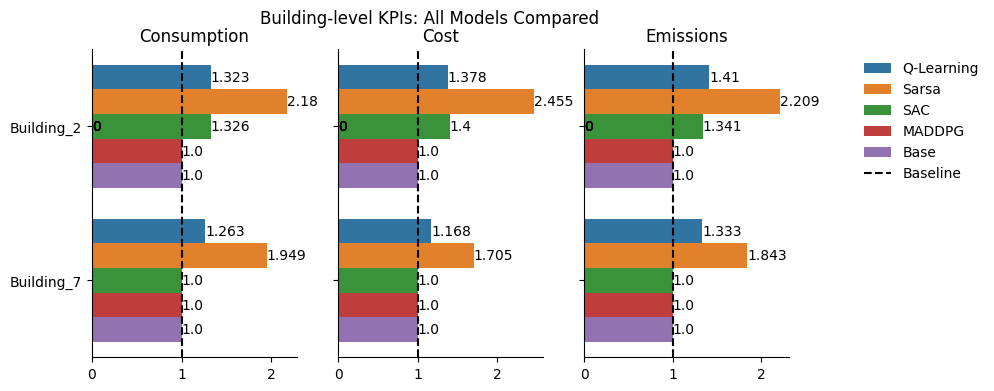

c:\Users\raffy\miniconda3\envs\citylearn\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.buildings to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.buildings` for environment variables or `env.get_wrapper_attr('buildings')` that will search the reminding wrappers.
  logger.warn(


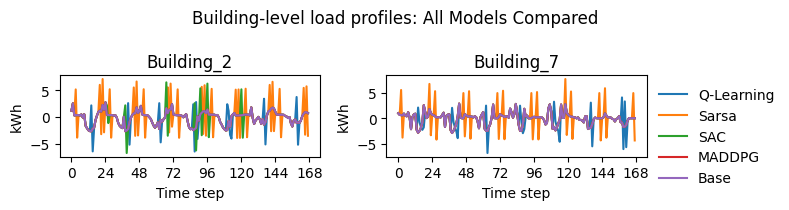

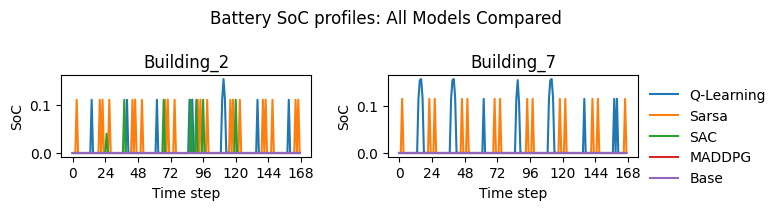

c:\Users\raffy\miniconda3\envs\citylearn\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.evaluate to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.evaluate` for environment variables or `env.get_wrapper_attr('evaluate')` that will search the reminding wrappers.
  logger.warn(
c:\Users\raffy\miniconda3\envs\citylearn\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.evaluate to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.evaluate` for environment variables or `env.get_wrapper_attr('evaluate')` that will search the reminding wrappers.
  logger.warn(


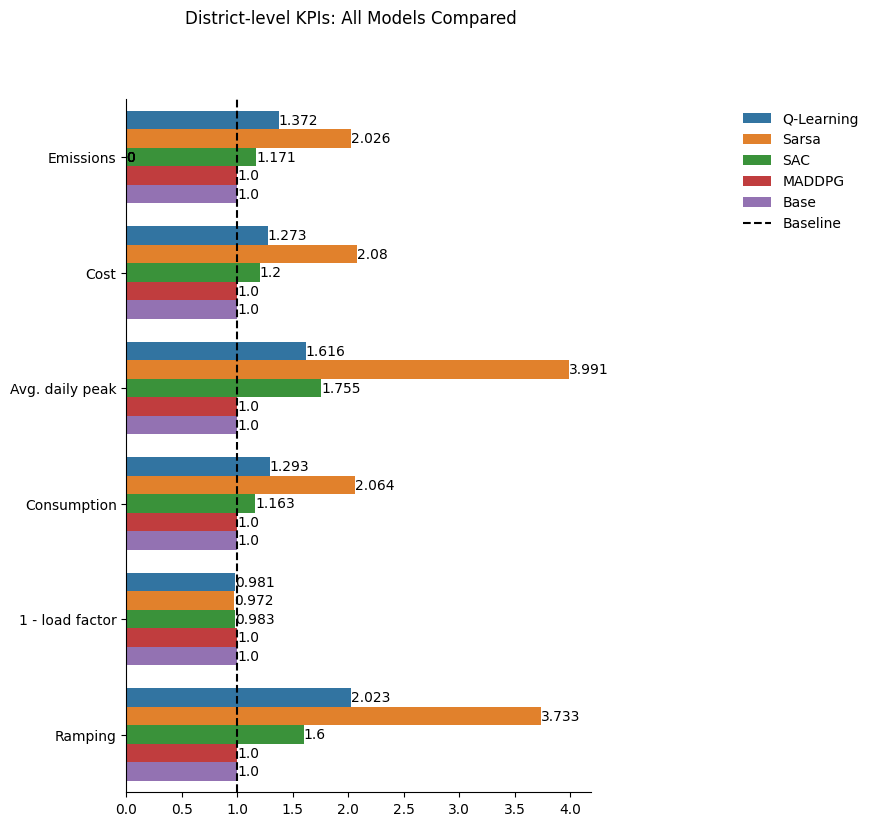

c:\Users\raffy\miniconda3\envs\citylearn\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.net_electricity_consumption to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.net_electricity_consumption` for environment variables or `env.get_wrapper_attr('net_electricity_consumption')` that will search the reminding wrappers.
  logger.warn(


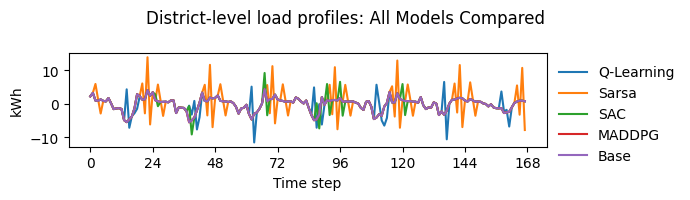

In [13]:
from functions.make_figures import plot_simulation_summary

plot_simulation_summary({'Q-Learning':q_env, 
                         'Sarsa': sarsa_env, 
                         'SAC':sac_env, 
                         'MADDPG':MADDPG_env, 
                         'Base': base_env},
                         "All Models Compared")

# Compare Tabular Models to Baseline

c:\Users\raffy\miniconda3\envs\citylearn\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.evaluate to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.evaluate` for environment variables or `env.get_wrapper_attr('evaluate')` that will search the reminding wrappers.
  logger.warn(
c:\Users\raffy\miniconda3\envs\citylearn\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.evaluate to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.evaluate` for environment variables or `env.get_wrapper_attr('evaluate')` that will search the reminding wrappers.
  logger.warn(


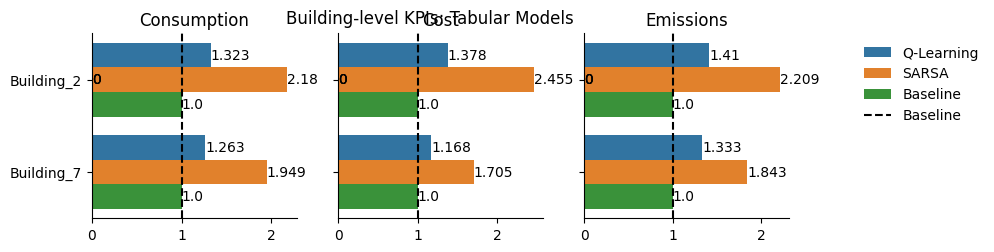

c:\Users\raffy\miniconda3\envs\citylearn\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.buildings to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.buildings` for environment variables or `env.get_wrapper_attr('buildings')` that will search the reminding wrappers.
  logger.warn(


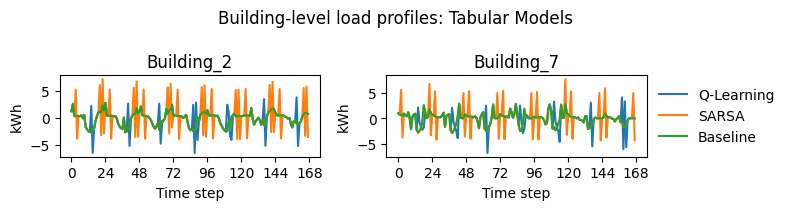

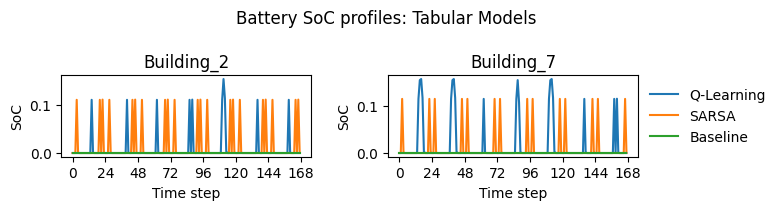

c:\Users\raffy\miniconda3\envs\citylearn\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.evaluate to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.evaluate` for environment variables or `env.get_wrapper_attr('evaluate')` that will search the reminding wrappers.
  logger.warn(
c:\Users\raffy\miniconda3\envs\citylearn\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.evaluate to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.evaluate` for environment variables or `env.get_wrapper_attr('evaluate')` that will search the reminding wrappers.
  logger.warn(


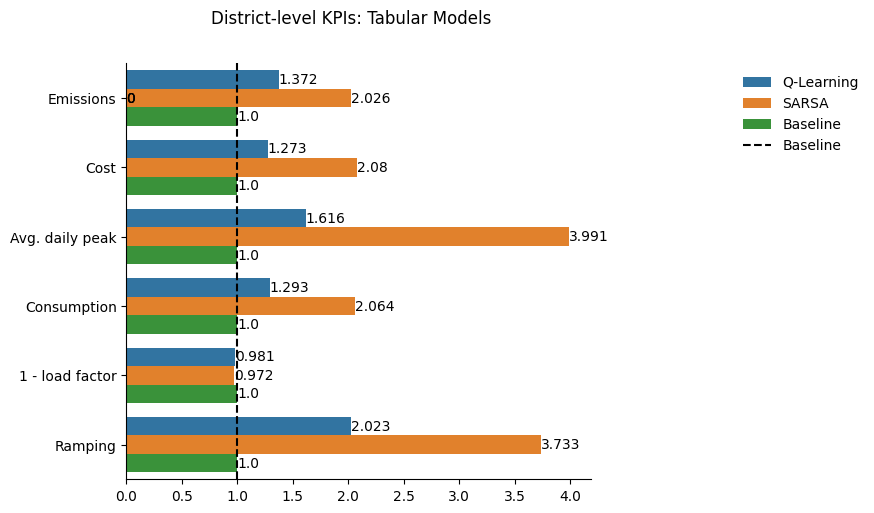

c:\Users\raffy\miniconda3\envs\citylearn\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.net_electricity_consumption to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.net_electricity_consumption` for environment variables or `env.get_wrapper_attr('net_electricity_consumption')` that will search the reminding wrappers.
  logger.warn(


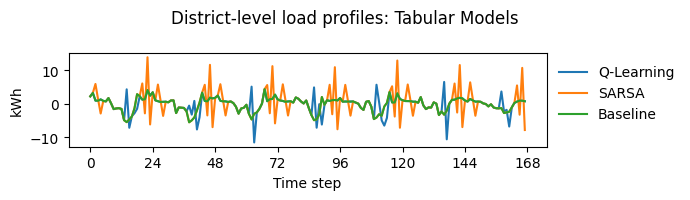

In [14]:
plot_simulation_summary({'Q-Learning':q_env, 
                         'SARSA':sarsa_env, 
                         'Baseline':base_env}, 
                         'Tabular Models')

# Compare Approximation Models to Baseline

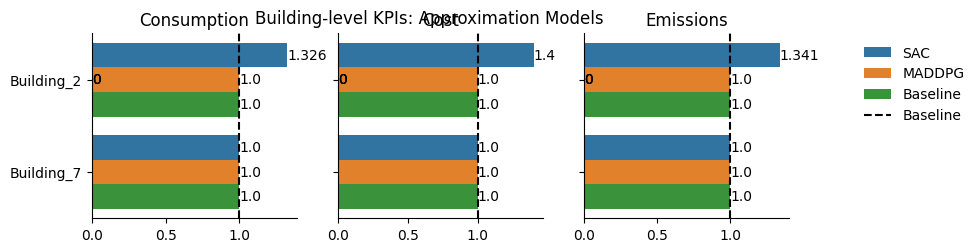

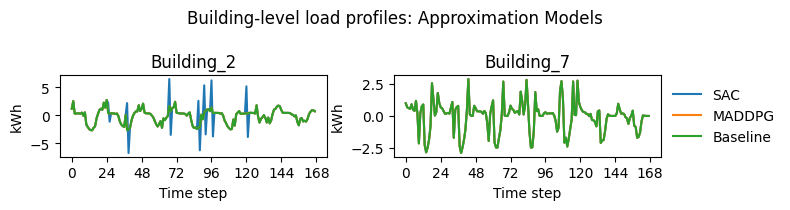

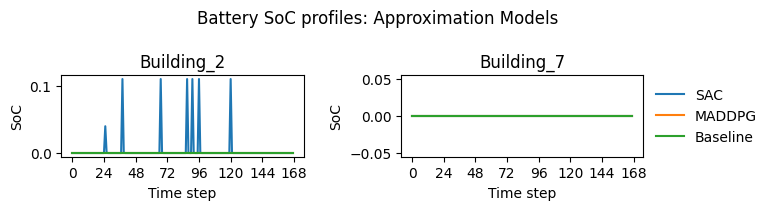

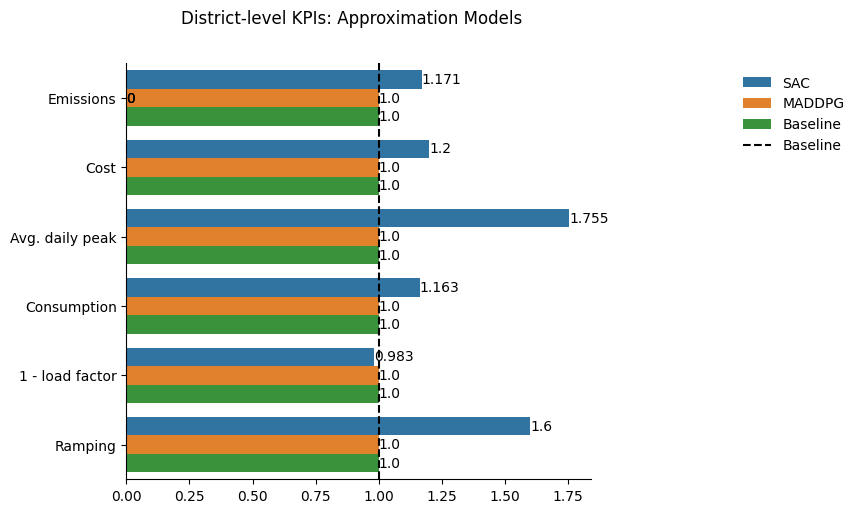

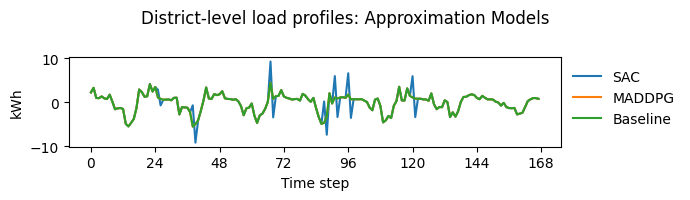

In [15]:
plot_simulation_summary({'SAC': sac_env,
                         'MADDPG': MADDPG_env,
                         'Baseline': base_env
                         },
                         'Approximation Models')

Explore approximators. Why are they performing exactly at baseline? 

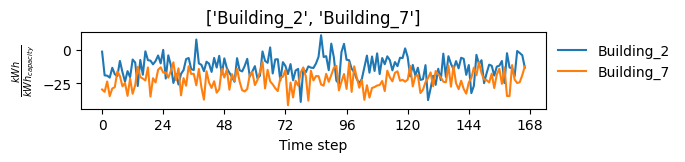

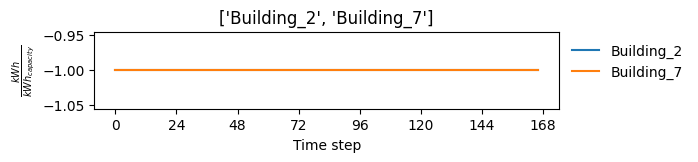

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
from functions.make_figures import plot_actions

plot_actions(sac_actions, buildings, sac_env)
plt.show()

mad_actions_lil = list(map(lambda a: a.tolist(), mad_actions)) # change from list of ndarray to list of list
plot_actions(mad_actions_lil, buildings, MADDPG_env)
plt.show()

# Train Approximators with Custom Reward Function
## MADDPG 

In [17]:
from agents.maddpg import MADDPGAgent, ReplayBuffer
import numpy as np
from tqdm import tqdm
from functions.reward_function import ReducedCostReward

# set up environment as 1 agent per building
schema['central_agent'] = False
MADDPG_env = CityLearnEnv(schema, random_seed=RANDOM_SEED, reward_function=ReducedCostReward)
obs = MADDPG_env.reset()
print(observations)

# set up parameters for agent and replay buffer
steps_per_episode = MADDPG_env.episode_time_steps
num_agents = len(MADDPG_env.buildings)
obs_dim = len(obs[0])
act_dim = MADDPG_env.action_space[0].shape[0]
device = 'cpu'

print(obs_dim, act_dim)
print(len(MADDPG_env.buildings))
print("Active Observations: ", MADDPG_env.observation_names)
print("Active Actions: ", MADDPG_env.action_names)

MADDPG_agent = MADDPGAgent(num_agents=num_agents, 
                           obs_dim=obs_dim, 
                           act_dim=act_dim,
                           device='cpu')

replay_buffer = ReplayBuffer(obs_dim=obs_dim, 
                             act_dim=act_dim,
                             num_agents=num_agents, 
                             device='cpu')

# ----------------- Train -----------------
for ep in tqdm(range(num_episodes)):
    obs, _ = MADDPG_env.reset()
    total_reward = 0.0
    for t in range(steps_per_episode):
        # Select actions with exploration
        action = MADDPG_agent.select_action(obs)

        # Step environment
        next_obs, rewards, done, *_ = MADDPG_env.step(action)

        # If rewards is a scalar or single value, broadcast to all agents
        if np.isscalar(rewards):
            rewards = np.array([rewards]*num_agents)

        # Store the transition
        replay_buffer.store(np.array(obs), np.array(action), rewards, np.array(next_obs), np.array([done]))

        # Update the agent (assuming enough samples)
        MADDPG_agent.update(replay_buffer)

        obs = next_obs
        total_reward += sum(rewards)

        if done:
            break

# ----------------- Test -----------------
# Initialize Environment
MADDPG_agent.noise_std = 0
observations, _ = MADDPG_env.reset()
done = False
mad_actions = []
while not done:
    actions = MADDPG_agent.select_action(observations)
    observations, reward, done, *_ = MADDPG_env.step(actions)

    mad_actions.append(actions)

kpis = MADDPG_env.evaluate()
kpis = kpis.pivot(index='cost_function', columns='name', values='value').round(3)
kpis = kpis.dropna(how='all')
display(kpis)

[[6, 23], [6, 23]]
2 1
2
Active Observations:  [['month', 'hour'], ['month', 'hour']]
Active Actions:  [['electrical_storage'], ['electrical_storage']]


100%|██████████| 30/30 [01:26<00:00,  2.89s/it]


name                                     Building_2  Building_7  District
cost_function                                                            
all_time_peak_average                           NaN         NaN     1.849
annual_normalized_unserved_energy_total       0.000         0.0     0.000
carbon_emissions_total                        1.078         1.0     1.039
cost_total                                    1.079         1.0     1.039
daily_one_minus_load_factor_average             NaN         NaN     0.995
daily_peak_average                              NaN         NaN     1.192
discomfort_cold_delta_average                 0.000         0.0     0.000
discomfort_cold_delta_maximum                 0.000         0.0     0.000
discomfort_cold_delta_minimum                 0.000         0.0     0.000
discomfort_hot_delta_average                  0.000         0.0     0.000
discomfort_hot_delta_maximum                  0.000         0.0     0.000
discomfort_hot_delta_minimum                  0.000         0.0     0.000
electricity_consumption_total                 1.097         1.0     1.048
monthly_one_minus_load_factor_average           NaN         NaN     0.982
ramping_average                                 NaN         NaN     1.057
zero_net_energy                               0.546         1.0     0.773

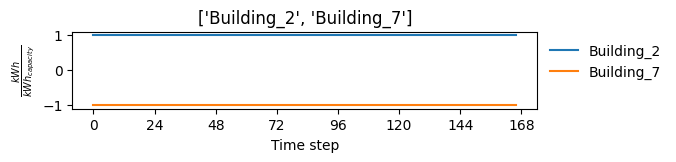

In [18]:
mad_actions_lil = list(map(lambda a: a.tolist(), mad_actions)) # change from list of ndarray to list of list
plot_actions(mad_actions_lil, buildings, MADDPG_env)
plt.show()

## SAC

In [19]:
num_episodes = 30
sac_env = CityLearnEnv(schema, random_seed=RANDOM_SEED, central_agent=False)
sac_env = NormalizedObservationWrapper(sac_env)

sac_kwargs = {
    'mini_batch_size':5,
    'tau': 0.005,
    'entropy_coeff': 0.2,
    'gamma': 0.99,
}


sac_agent = SAC(
    env=sac_env,
    random_seed=RANDOM_SEED,
    **sac_kwargs
)
# ----------------- Train -----------------
_ = sac_agent.learn(episodes=num_episodes)

# ----------------- Test -----------------
# Initialize Environment
observations, _ = sac_env.reset()
sac_actions = []
while not sac_env.terminated:
    actions = sac_agent.predict(observations, deterministic=True)
    observations, reward, info, terminated, truncated = sac_env.step(actions)
    sac_actions.append(actions)

kpis = sac_agent.env.evaluate()
kpis = kpis.pivot(index='cost_function', columns='name', values='value').round(3)
kpis = kpis.dropna(how='all')
display(kpis)

100%|██████████| 30/30 [01:36<00:00,  3.21s/it]
c:\Users\raffy\miniconda3\envs\citylearn\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.terminated to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.terminated` for environment variables or `env.get_wrapper_attr('terminated')` that will search the reminding wrappers.
  logger.warn(
c:\Users\raffy\miniconda3\envs\citylearn\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.evaluate to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.evaluate` for environment variables or `env.get_wrapper_attr('evaluate')` that will search the reminding wrappers.
  logger.warn(


name                                     Building_2  Building_7  District
cost_function                                                            
all_time_peak_average                           NaN         NaN       1.0
annual_normalized_unserved_energy_total         0.0         0.0       0.0
carbon_emissions_total                          1.0         1.0       1.0
cost_total                                      1.0         1.0       1.0
daily_one_minus_load_factor_average             NaN         NaN       1.0
daily_peak_average                              NaN         NaN       1.0
discomfort_cold_delta_average                   0.0         0.0       0.0
discomfort_cold_delta_maximum                   0.0         0.0       0.0
discomfort_cold_delta_minimum                   0.0         0.0       0.0
discomfort_hot_delta_average                    0.0         0.0       0.0
discomfort_hot_delta_maximum                    0.0         0.0       0.0
discomfort_hot_delta_minimum                    0.0         0.0       0.0
electricity_consumption_total                   1.0         1.0       1.0
monthly_one_minus_load_factor_average           NaN         NaN       1.0
ramping_average                                 NaN         NaN       1.0
zero_net_energy                                 1.0         1.0       1.0

c:\Users\raffy\miniconda3\envs\citylearn\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.buildings to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.buildings` for environment variables or `env.get_wrapper_attr('buildings')` that will search the reminding wrappers.
  logger.warn(


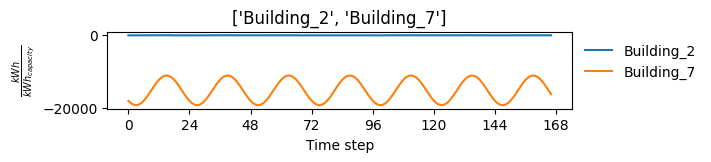

In [20]:
plot_actions(sac_actions, buildings, sac_env)
plt.show()